# Credit Score / Repay Prediction

In this project, we will aim to use "credit scoring sample" dataset to predict whether a customer will repay their debt within 90 days or not. This is essentially a binary classification task that categorizes customers into two groups: good payers and bad payers. 

To this end, we will use methods and models like bootstrapping, random forests, bagging and logistic regression.

## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# Dataset

In [2]:
data_loc = './Data/credit_scoring_sample.csv'

data = pd.read_csv(data_loc, delimiter=';')

## Explanatory Data Analysis

In [3]:
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [4]:
data

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0
...,...,...,...,...,...,...,...,...
45058,1,31,0,0.824725,0,0,3000.0,1.0
45059,0,49,0,6530.000000,0,0,0.0,5.0
45060,1,38,0,0.475841,0,0,3000.0,2.0
45061,0,47,1,0.485198,0,0,11720.0,5.0


In [5]:
data.shape

(45063, 8)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45063 entries, 0 to 45062
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      45063 non-null  int64  
 1   age                                   45063 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  45063 non-null  int64  
 3   DebtRatio                             45063 non-null  float64
 4   NumberOfTimes90DaysLate               45063 non-null  int64  
 5   NumberOfTime60-89DaysPastDueNotWorse  45063 non-null  int64  
 6   MonthlyIncome                         36420 non-null  float64
 7   NumberOfDependents                    43946 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 2.8 MB


Find the percentage of missing data in each feature.

In [7]:
def calculate_missing_data_percentage(data):
    # Calculate the percentage of missing data for each feature
    missing_data_percentage = data.isnull().mean() * 100
    missing_data_df = pd.DataFrame({
        'Feature': missing_data_percentage.index,
        'Percentage Missing': missing_data_percentage.values
    })
    
    # Sort the DataFrame by percentage missing in descending order
    missing_data_df = missing_data_df.sort_values(by='Percentage Missing', ascending=False)
    
    return missing_data_df

missing_data = calculate_missing_data_percentage(data)
missing_data

,Feature,Percentage Missing
6,MonthlyIncome,19.179815
7,NumberOfDependents,2.478752
0,SeriousDlqin2yrs,0.000000
1,age,0.000000
2,NumberOfTime30-59DaysPastDueNotWorse,0.000000
3,DebtRatio,0.000000
4,NumberOfTimes90DaysLate,0.000000
5,NumberOfTime60-89DaysPastDueNotWorse,0.000000


Plot the distribution of the target column (SeriousDlqin2yrs).

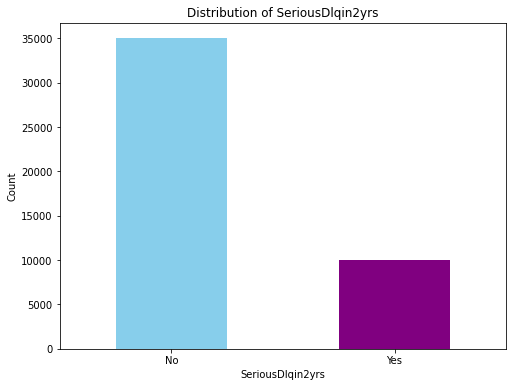

In [16]:
plt.figure(figsize=(8, 6))
data['SeriousDlqin2yrs'].value_counts().plot(kind='bar', color=['skyblue', 'purple'])
plt.title('Distribution of SeriousDlqin2yrs')
plt.xlabel('SeriousDlqin2yrs')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
plt.savefig("chart1.png", dpi=400)
plt.show()

## Preprocessing and Normalization

In this step, we replace missing values in each input column with the median of the respective column.

In [9]:
data.fillna(data.median(), inplace=True)

# Use the previous function to make sure no data is missing now
missing_data = calculate_missing_data_percentage(data)
missing_data

,Feature,Percentage Missing
0,SeriousDlqin2yrs,0.0
1,age,0.0
2,NumberOfTime30-59DaysPastDueNotWorse,0.0
3,DebtRatio,0.0
4,NumberOfTimes90DaysLate,0.0
5,NumberOfTime60-89DaysPastDueNotWorse,0.0
6,MonthlyIncome,0.0
7,NumberOfDependents,0.0


## I. Bootstrapping

1. Estimate the interval in which the mean age of bad payers (customers who did not repay their debt within 90 days) falls, with a 90% confidence level.

In [10]:
# Select age of the bad payers from the dataset
bad_payers_age = data[data['SeriousDlqin2yrs'] == 1]['age']

# Bootstrap sampling
np.random.seed(0)
bootstrap_iterations = 20000
bootstrap_size = int(len(bad_payers_age))
means = []

for _ in range(bootstrap_iterations):
    sample = np.random.choice(bad_payers_age, size=bootstrap_size, replace=True)
    means.append(np.mean(sample))

# Calculate the 90% confidence interval
alpha = 0.10
lower_bound = np.percentile(means, alpha/2 * 100)
upper_bound = np.percentile(means, (1 - alpha/2) * 100)

(lower_bound, upper_bound)

(45.714437462597246, 46.14033512866547)

The resulting confidence interval is 
$$(45.714437462597246, 46.14033512866547)$$

## II. Random Forest

2. Here, we find the optimal Random Forest classifier with 100 trees using the following given set of parameters. 
    ```
    parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}
    ```
    We make use of the stratified 5-fold validation and grid search to find the optimal values for each parameter. Finally, we report the ROC AUC score for the optimal classifier.

In [11]:
# Define the given parameteres
parameters = {
    'max_features': [1, 2, 4],
    'min_samples_leaf': [3, 5, 7, 9],
    'max_depth': [5, 10, 15]
}

# Create random forest classifier
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0)

# Set up stratified 5-fold validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Grid search
grid_search = GridSearchCV(estimator=rf, param_grid=parameters, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(data.drop(columns=['SeriousDlqin2yrs']), data['SeriousDlqin2yrs'])

# Obtain the optimal parameters and AUC score
best_parameters = grid_search.best_params_
best_AUC_score = grid_search.best_score_

print(f"Best Parameters: {best_parameters}")
print(f"Best ROC AUC Score: {best_AUC_score}")

Best Parameters: {'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 9}
Best ROC AUC Score: 0.8354378802831613


The best set of parameters are:
```
{'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 9}
```
and the best AUC score is $0.8354378802831613$

3. To find which feature has the weakest impact on the Random Forest model, we can look at the feature importances. Feature importances in a Random Forest model show how much each of the features contribute to the model's predictions. The feature with the lowest importance score will be our answer.
To this end we can find the importance scores and even plot them to find the lowest score.



Weakest Feature: NumberOfDependents, Importance: 0.01902918451822596


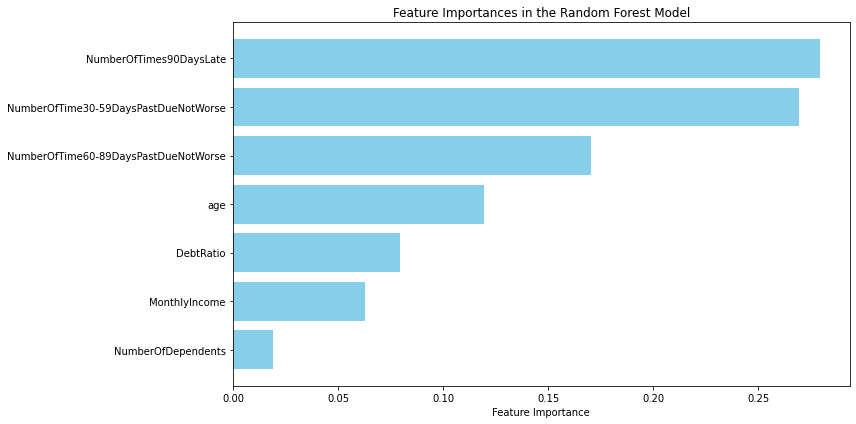

In [12]:
# Create and train the Random Forest model with the best parameters from the earlier grid search
rf_best = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    max_features=best_parameters['max_features'],
    min_samples_leaf=best_parameters['min_samples_leaf'],
    max_depth=best_parameters['max_depth'],
    random_state=0
)

# Fit the model
rf_best.fit(data.drop(columns=['SeriousDlqin2yrs']), data['SeriousDlqin2yrs'])

# Find feature importances
importances = rf_best.feature_importances_
feature_names = data.drop(columns=['SeriousDlqin2yrs']).columns
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1])

# Show the feature with the least feature importance or impact
weakest_feature = feature_importance[0]
print(f"Weakest Feature: {weakest_feature[0]}, Importance: {weakest_feature[1]}")

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh([x[0] for x in feature_importance], [x[1] for x in feature_importance], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances in the Random Forest Model')
plt.tight_layout()
plt.savefig("chart2.png", dpi=400)
plt.show()

As we can see, the feature with the weakest impact is "NumberOfDependents" with importance of about $0.019$.

## III. Bagging Classifier

4. Now we find the optimal parameters for a Bagging classifier using randomized search and stratified 5-fold validation. The options are:
    ```
    parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9],
    'estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]}
    ```
    We will use Logistic Regression as the base classifier.

In [13]:
# Given parameters from the problem
parameters = {
    'max_features': [2, 3, 4],
    'max_samples': [0.5, 0.7, 0.9],
    'estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]
}

# Logistic regression used as the base estimator
base_estimator = LogisticRegression(max_iter=1000, solver='liblinear')

# Bagging classifier
bagging = BaggingClassifier(estimator=base_estimator, n_estimators=100, random_state=0)

# Stratified 5-fold validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Randomized search to find optimal parameters
random_search = RandomizedSearchCV(estimator=bagging, param_distributions=parameters, n_iter=20, cv=cv, scoring='roc_auc', n_jobs=-1, random_state=0)
random_search.fit(data.drop(columns=['SeriousDlqin2yrs']), data['SeriousDlqin2yrs'])

# Get the best parameters and the corresponding ROC AUC score
best_parameters2 = random_search.best_params_
best_AUC_score2 = random_search.best_score_

print(f"Best Parameters: {best_parameters2}")
print(f"Best ROC AUC Score: {best_AUC_score2}")

Best Parameters: {'max_samples': 0.5, 'max_features': 2, 'estimator__C': 100}
Best ROC AUC Score: 0.7611354363025876


Now let us justify why such a set of parameters might be best.

+ **max_samples = 0.5**:
    This value means that each base estimator (Logistic Regression) in the Bagging is trained on a random subset making up 50% of the training data.

    Using only half of the data for each base estimator introduces diversity among the models. This diversity helps to reduce overfitting, as each base estimator can capture different regions of the feature space. This is an advatage of ensemble methods. This is one justification for why this value exactly.

+ **max_features = 2**:
    This value means that each base estimator is trained using a random subset of 2 features. Limiting to smaller values of max_feature allows for promotion of more diversity and again less overfitting.

+ **estimator__C = 100**:
    This value sets the regularization parameter C for the Logistic Regression base estimator to 100, causing weaker regularization.

    While weak regularization increases the risk of overfitting, in the context of Bagging, it can be way to balance the tradeoff between bias and variance. Also fitting more closely to the training set will lead to smaller training error. This also allows for more flexibility in the logistic regression models.
